# Google LightweightMMM
https://github.com/google/lightweight_mmm

Note: make sure to restart runtime to use new versions of libraries

In [43]:
# Import jax.numpy and numpyro
import jax.numpy as jnp
import numpyro
numpyro.set_host_device_count(2)

In [44]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

## Simulating the data for modeling

In [45]:
# 104 weeks of training data + 13 weeks of test data
data_size = 104 + 13
n_media_channels = 3
n_extra_features = 1
n_geos = 2

In [46]:
# simulate the data
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=data_size,
    n_media_channels=n_media_channels,
    n_extra_features=n_extra_features,
    geos=n_geos)

In [47]:
# 117 rows, 3 media channels, 2 geos
media_data.shape

(117, 3, 2)

In [48]:
# split train and test data
split_point = data_size - 13

# media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

# extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]

# target
target_train = target[:split_point]

In [49]:
# create the scalers
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

# scale the data
media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

In [50]:
# training the model
mmm = lightweight_mmm.LightweightMMM(model_name="carryover")

mmm.fit(
    media=media_data_train,
    total_costs=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=2000,
    number_samples=2000,
    number_chains=2)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [51]:
# check the summary
# rhats should be < 1.1
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.52      0.29      0.53      0.10      1.00   5135.12      1.00
ad_effect_retention_rate[1]      0.48      0.29      0.46      0.00      0.89   4607.95      1.00
ad_effect_retention_rate[2]      0.46      0.11      0.46      0.28      0.64   1155.40      1.00
   beta_extra_features[0,0]     -0.31      0.04     -0.31     -0.38     -0.24   2072.90      1.00
   beta_extra_features[0,1]     -0.30      0.04     -0.30     -0.38     -0.24   1640.46      1.00
            beta_media[0,0]      0.01      0.01      0.00      0.00      0.02   2555.21      1.00
            beta_media[0,1]      0.01      0.01      0.00      0.00      0.02   3137.60      1.00
            beta_media[1,0]      0.02      0.02      0.01      0.00      0.04   3684.42      1.00
            beta_media[1,1]      0.01      0.02      0.01      0.00      0.04   2793.24      1.00
            beta_me

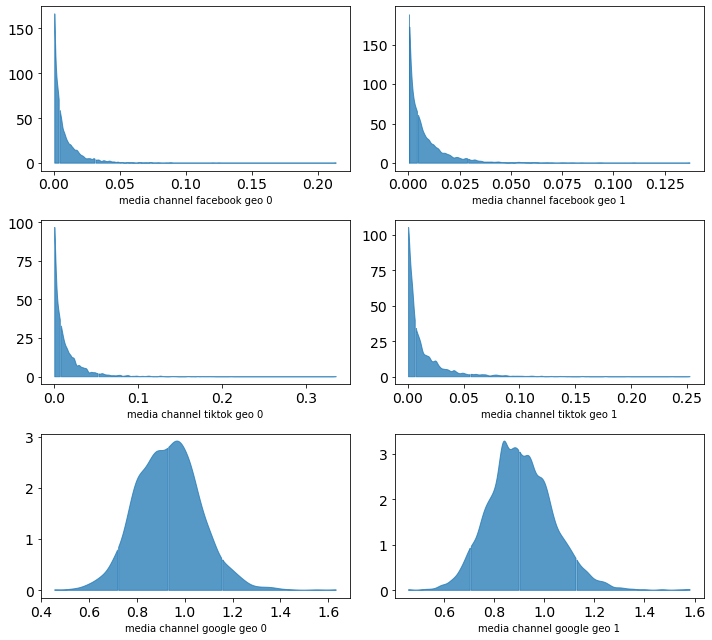

In [52]:
# plot the posterior distributions of the media effects
channel_names = ['facebook', 'tiktok', 'google']
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=channel_names)

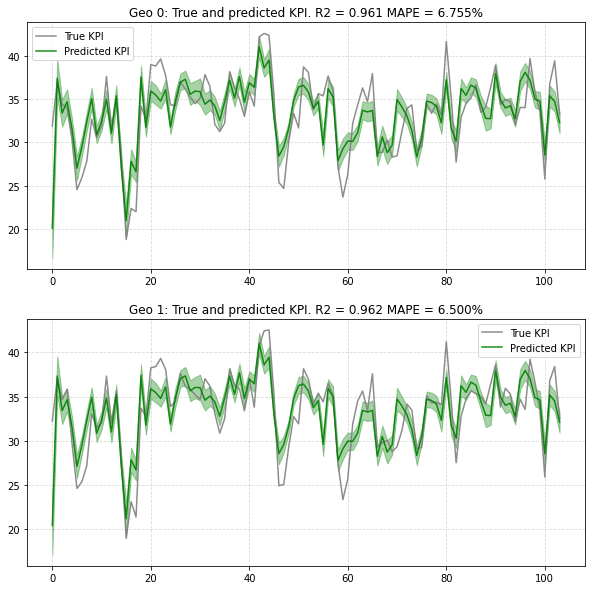

In [53]:
# check the model predicts training data
# passing the scaler gives unscaled results
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [54]:
# scale the test media data to make predictions on unseen data
media_data_test = media_scaler.transform(media_data_test)
extra_features_test = extra_features_scaler.transform(extra_features_test)
new_predictions = mmm.predict(media=media_data_test,
                              extra_features=extra_features_test)
new_predictions.shape

(4000, 13, 2)

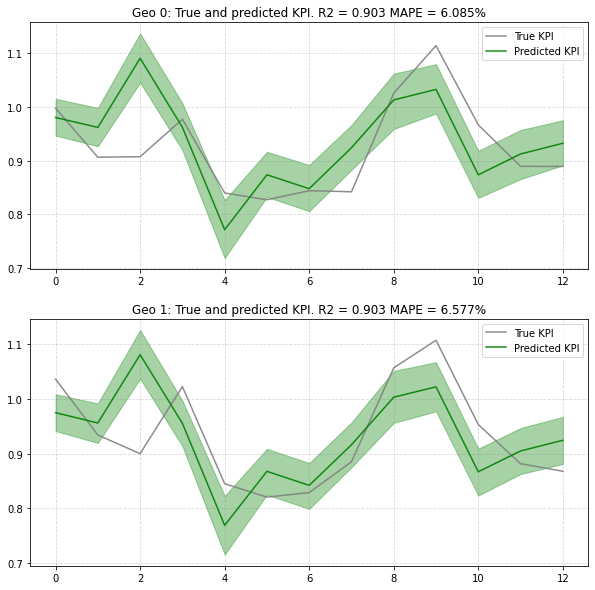

In [55]:
# plot the prediction vs actual charts
target_test = target_scaler.transform(target[split_point:])
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_test)

In [56]:
# estimate media effects with their respective credibility intervals
media_effect, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

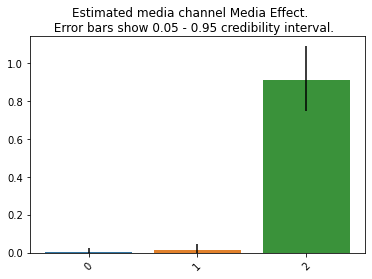

In [57]:
# plot media effects
plot.plot_bars_media_metrics(metric=media_effect, metric_name="Media Effect")

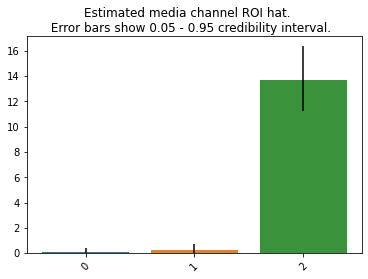

In [58]:
# plot media roi
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

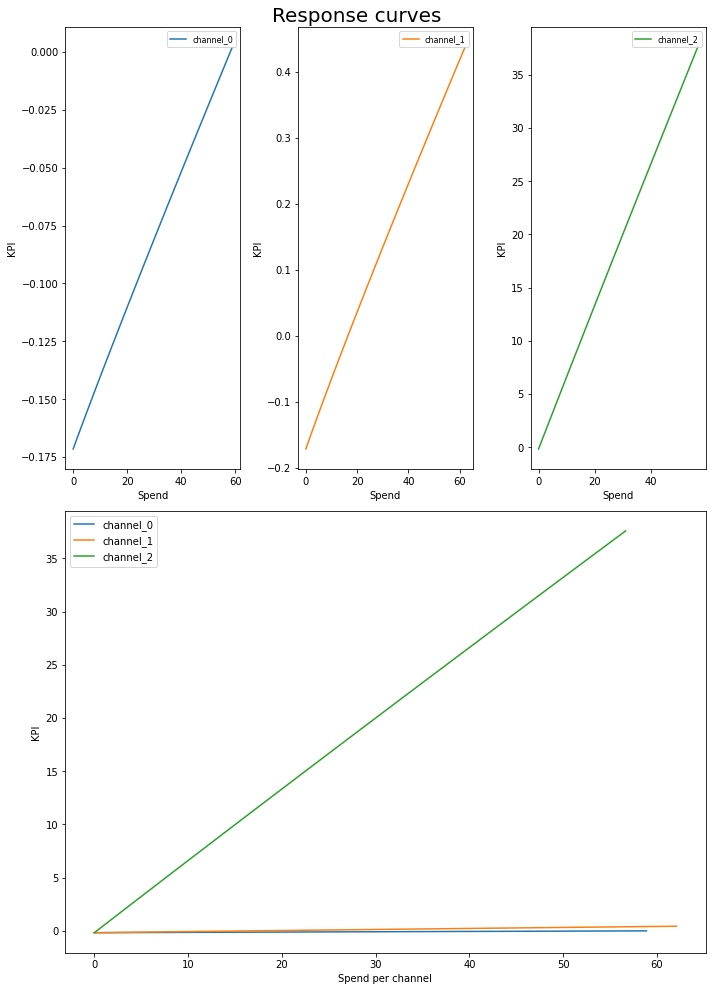

In [59]:
# plot response curves for channels
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, media_scaler=media_scaler)

## Budget Optimization

In [60]:
# if you used impressions for media variables, this should be an array of average CPMs
# if you used spend then just put an array of 1s like we did here
prices = jnp.ones(mmm.n_media_channels)

In [61]:
# starting with the same average weekly budget and average values for extra features
n_time_periods = 10
budget = jnp.sum(media_data.mean(axis=0)) * n_time_periods
extra_features_forecast = extra_features_scaler.transform(extra_features_test)[:n_time_periods]

In [62]:
# run budget optimization
solution = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_forecast,
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -811.6899014689226
            Iterations: 8
            Function evaluations: 32
            Gradient evaluations: 8


In [63]:
# both values should be almost equal
budget, jnp.sum(solution[2] * prices[2])

(DeviceArray(1191.5483, dtype=float32), DeviceArray(1191.5482, dtype=float32))

In [64]:
print(range(len(solution)))

for x in range(len(solution[2])):
    share = round(solution[2] / jnp.sum(solution[2] * prices)*100, 2)
    print(channel_names[2], ": ", share, "%")

range(0, 3)
google :  [33.16     33.51     33.329998] %
google :  [33.16     33.51     33.329998] %
google :  [33.16     33.51     33.329998] %


In [65]:
mmm.print_summary()
plot.plot_model_fit(media_mix_model=mmm, target_scaler=target_scaler)
prediction = mmm.predict(
    media=media_data_test,
    extra_features=extra_data_test,
    target_scaler=target_scaler
)
mmm.print_summary()
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_names)
plot.plot_response_curves(media_mix_model=mmm, media_scaler=media_scaler, target_scaler=target_scaler)
media_effect_hat, roi_hat = mmm.get_posterior_metrics()
plot.plot_bars_media_metrics(metric=media_effect_hat, channel_names=media_names)
plot.plot_bars_media_metrics(metric=roi_hat, channel_names=media_names)
# Run media optimization.
budget = 40 # your budget here
prices = np.array([0.1, 0.11, 0.12])
extra_features_test = extra_features_scaler.transform(extra_features_test)
solution = optimize_media.find_optimal_budgets(
    n_time_periods=extra_features_test.shape[0],
    media_mix_model=mmm,
    budget=budget,
    extra_features=extra_features_test,
    prices=prices)


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.52      0.29      0.53      0.10      1.00   5135.12      1.00
ad_effect_retention_rate[1]      0.48      0.29      0.46      0.00      0.89   4607.95      1.00
ad_effect_retention_rate[2]      0.46      0.11      0.46      0.28      0.64   1155.40      1.00
   beta_extra_features[0,0]     -0.31      0.04     -0.31     -0.38     -0.24   2072.90      1.00
   beta_extra_features[0,1]     -0.30      0.04     -0.30     -0.38     -0.24   1640.46      1.00
            beta_media[0,0]      0.01      0.01      0.00      0.00      0.02   2555.21      1.00
            beta_media[0,1]      0.01      0.01      0.00      0.00      0.02   3137.60      1.00
            beta_media[1,0]      0.02      0.02      0.01      0.00      0.04   3684.42      1.00
            beta_media[1,1]      0.01      0.02      0.01      0.00      0.04   2793.24      1.00
            beta_me

NameError: ignored